In [36]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import time
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix

from sklearn.utils import resample

In [37]:
import os
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [38]:
data = pd.read_csv('data/modified_utc_dataset.csv')

# Initial data exploration
print(data.head())

   Duration Protocol Direction State  Source_Type_of_Service  \
0  1.026539      tcp        ->  S_RA                     0.0   
1  1.009595      tcp        ->  S_RA                     0.0   
2  3.056586      tcp        ->  SR_A                     0.0   
3  3.111769      tcp        ->  SR_A                     0.0   
4  3.083411      tcp        ->  SR_A                     0.0   

   Destination_Type_of_Service  Total_Packets  Total_Bytes  Source_Bytes  \
0                          0.0              4          276           156   
1                          0.0              4          276           156   
2                          0.0              3          182           122   
3                          0.0              3          182           122   
4                          0.0              3          182           122   

                                    Label  
0  flow=Background-Established-cmpgw-CVUT  
1  flow=Background-Established-cmpgw-CVUT  
2             flow=Backgro

In [39]:
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()

**Feature selection**
- we have seen the correlation between 'Total_Packets' and 'Total_Bytes' is approximately one.
- The 'label's purpose is to help us identify whether the observation is from a botnet or not.

In [40]:
columns_to_drop = ['Label', 'Total_Bytes']
columns_to_drop = [col for col in columns_to_drop if col in data.columns]

data['botnet'] = data['Label'].apply(lambda x: 1 if 'flow=From-Botnet' in x else 0)

data = data.drop(columns_to_drop, axis =1)

In [41]:
# Encoding categorical features into numerical
data['Protocol'] = data['Protocol'].astype('category').cat.codes
data['Protocol'] = data['Protocol'].astype(np.int32)
data['Direction'] = data['Direction'].astype('category').cat.codes
data['Direction'] = data['Direction'].astype(np.int32)
data['State'] = data['State'].astype('category').cat.codes
data['State'] = data['State'].astype(np.int32)

In [42]:
class_1_upsampled = resample(data[data['botnet'] == 1], 
                             replace=True,    # sample with replacement
                             n_samples=100000, # match number in majority class
                             random_state=42) # reproducible results

# Downsample class 0 to 100,000 samples
class_0_downsampled = resample(data[data['botnet'] == 0], 
                               replace=False,    # sample without replacement
                               n_samples=100000, # number of samples
                               random_state=42) # reproducible results

# Combine the upsampled minority class with the downsampled majority class
df_resampled = pd.concat([class_0_downsampled, class_1_upsampled])

In [47]:
X = df_resampled.drop('botnet', axis =1)
y = df_resampled['botnet']

## Feature importance 
**Some features doesn't even have a single observation representing the other class**

In [48]:
# Check for zero variance features and remove them
variance = X.var()
zero_variance_features = variance[variance == 0].index
if len(zero_variance_features) > 0:
    X.drop(columns=zero_variance_features, inplace=True)


In [49]:
# Apply chi-squared test and create a dictionary that holds the p-value and the features.
chi_scores, p_values = chi2(X, y)
chi2_results = {feature: p_value for feature, p_value in zip(X.columns, p_values)}

print(chi2_results)

{'Duration': 0.0, 'Protocol': 6.582909571480221e-108, 'Direction': 0.0, 'State': 0.0, 'Source_Type_of_Service': 1.2242733218706717e-89, 'Destination_Type_of_Service': 5.644889060545041e-17, 'Total_Packets': 0.0, 'Source_Bytes': 0.0}


## Class Imbalance
The dataset exhibits a significant class imbalance between two classes: 'not-botnet' (0) and 'botnet' (1). Here is the distribution:

'not-botnet' (0): 1,587,187 instances
'botnet' (1): 33,986 instances
This class distribution indicates a severe imbalance, where the majority class ('not-botnet') heavily outweighs the minority class ('botnet').

In [50]:
# Normalize the feature data (if necessary for the specific context)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [51]:
def create_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Custom KerasClassifier wrapper
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn=None, epochs=1, batch_size=32, verbose=0, **kwargs):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.kwargs = kwargs
        self.model_ = None

    def fit(self, X, y, **kwargs):
        # Ensure y is correctly shaped
        if len(y.shape) == 3:
            y = np.squeeze(y)
        self.model_ = self.build_fn(**self.kwargs)




















    

    def predict(self, X, **kwargs):
        return np.argmax(self.model_.predict(X), axis=1)
# Wrap the model using the custom wrapper
model = KerasClassifierWrapper(build_fn=create_model, epochs=20, batch_size=64, verbose=1)

# Define hyperparameters for GridSearchCV
params = {
    'epochs': [50],
    'batch_size': [64]
}

# Hyperparameter tuning and model evaluation
grid = GridSearchCV(model, param_grid=params, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

# Plot training history
history = grid.best_estimator_.model_.history.history


Epoch 1/50
15253/15253 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.9767 - loss: 0.1032
Epoch 2/50
15253/15253 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.9821 - loss: 0.0805
Epoch 3/50
15253/15253 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.9819 - loss: 0.0810
Epoch 4/50
15253/15253 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.9822 - loss: 0.0804
Epoch 5/50
15253/15253 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.9820 - loss: 0.0803
Epoch 6/50
15253/15253 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.9820 - loss: 0.0805
Epoch 7/50
15253/15253 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.9820 - loss: 0.0807
Epoch 8/50
15253/15253 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.9822 - loss: 0.0800
Epoch 9/50
15253/15253 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9823 - loss: 0.0793
Epoch 10/50
15253/15253 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9819 - loss: 0.0827
Epoch 11/50
15253/15253 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9820 - loss: 0.08

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



15253/15253 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.9821 - loss: 0.0952
Epoch 1/50
19066/19066 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - accuracy: 0.9821 - loss: 0.0797
Epoch 3/50
19066/19066 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.9821 - loss: 0.0810
Epoch 4/50
19066/19066 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - accuracy: 0.9819 - loss: 0.0867
Epoch 21/50
19066/19066 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.9821 - loss: 0.0810
Epoch 22/50
19066/19066 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.9823 - loss: 0.0803
Epoch 27/50
19066/19066 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.9822 - loss: 0.0837
Epoch 28/50
19066/19066 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.9823 - loss: 0.0816
Epoch 36/50
19066/19066 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.9819 - loss: 0.0935
Epoch 43/50
19066/19066 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.9821 - loss: 0.0831
Epoch 44/50
19066/19066 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.9822 - loss: 0.0813
Epo

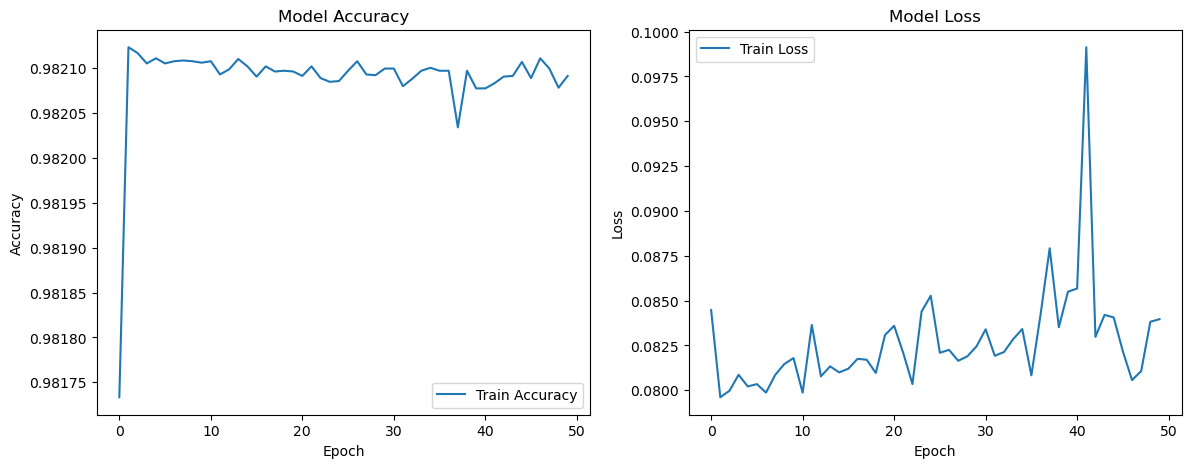

9533/9533 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
Accuracy: 0.9818390427798721
Precision: 0.9640079059268957
Recall: 0.9818390427798721
F1-Score: 0.9728417748544379
ROC-AUC: 0.5


In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
ax1.plot(history['accuracy'], label='Train Accuracy')
#ax1.plot(history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history['loss'], label='Train Loss')
#ax2.plot(history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

# Evaluate on test set
y_pred = grid.best_estimator_.predict(X_test)

# Convert predictions and true labels from categorical to binary
y_pred_binary = np.argmax(to_categorical(y_pred), axis=1)
y_test_binary = np.argmax(y_test, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary, average='weighted')
recall = recall_score(y_test_binary, y_pred_binary, average='weighted')
f1 = f1_score(y_test_binary, y_pred_binary, average='weighted')
roc_auc = roc_auc_score(y_test_binary, to_categorical(y_pred_binary), multi_class='ovr')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"ROC-AUC: {roc_auc}")


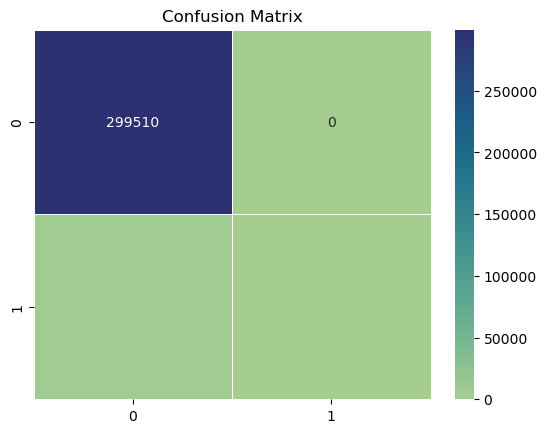

In [53]:
 # Plot confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)
sns.heatmap(cm, annot=True, cmap = 'crest', fmt='d', linewidth=.5)
plt.title(f'Confusion Matrix')
plt.show()

In [54]:
cm

array([[299510,      0],
       [  5540,      0]], dtype=int64)